In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import itertools
import lightgbm as lgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import matplotlib.pyplot as plt

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [3]:
%time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

Wall time: 4.86 s


(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [4]:
mask_date = df.index.get_level_values('date')>='2016-01-01'
# df_baseline = df.loc[mask_date,'r'].agg(agg_operations[:-1])
# df_baseline_q = df.loc[mask_date,'r'].reset_index('code').resample('Q').agg(agg_operations)
# df_baseline
# df_baseline_q

mean     -0.003319
median   -0.021764
max       5.543209
min      -0.972953
std       0.094291
Name: r, dtype: float64

r                                                
                mean    median       max       min       std    size
date                                                                
2016-03-31  0.001993 -0.018907  3.210775 -0.972953  0.106063  150433
2016-06-30  0.001559 -0.020861  1.944000 -0.714186  0.094675  155157
2016-09-30  0.007954 -0.008368  2.405940 -0.651400  0.083539  170115
2016-12-31 -0.007982 -0.018912  2.487285 -0.900237  0.071205  165772
2017-03-31  0.000778 -0.012563  1.463308 -0.482470  0.076877  170618
2017-06-30 -0.013874 -0.030237  5.543209 -0.852388  0.088826  178502
2017-09-30  0.007274 -0.008121  1.925995 -0.804020  0.080761  200686
2017-12-31 -0.021151 -0.031991  1.990148 -0.814664  0.063842  193463
2018-03-31 -0.013712 -0.029727  1.814716 -0.967228  0.089663  190955
2018-06-30 -0.027349 -0.036075  1.174034 -0.950667  0.068656  197214
2018-09-30 -0.026512 -0.033389  1.554622 -0.869820  0.057996  218246
2018-12-31  0.002983 -0.020253  2.526171 -0.612903  0.094861  210707
2019-03-31  0.065352  0.012469  2.550678 -0.746753  0.163316  206870
2019-06-30 -0.015648 -0.027737  2.430079 -0.861940  0.070399  215321
2019-09-30 -0.000834 -0.021739  2.231214 -0.876993  0.084032  236958
2019-12-31  0.009239 -0.009906  2.763278 -0.731959  0.107321  225939
2020-03-31 -0.018712 -0.030406  2.382353 -0.763889  0.113561  218582
2020-06-30 -0.015541 -0.027642  1.050950 -0.787500  0.063938  148256

In [7]:
mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    df.index.get_level_values('code').str[:3]!='688',
]

mask_baseline2 = True

for m in mask_basic+[mask_date]:

    mask_baseline2 &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_baseline2.sum()/len(mask_baseline2),4)


df_baseline2 = df.loc[mask_baseline2,'r'].agg(agg_operations[:-1])
df_baseline2_q = df.loc[mask_baseline2,'r'].reset_index('code').resample('Q').agg(agg_operations)
df_baseline2
df_baseline2_q

(1056950, 4593560, 0.2301, 0.2301)

(4348257, 4593560, 0.9466, 0.1915)

(2056374, 4593560, 0.4477, 0.1672)

(1433930, 4593560, 0.3122, 0.1327)

(4580262, 4593560, 0.9971, 0.1326)

(3453794, 4593560, 0.7519, 0.0855)

mean     -0.006251
median   -0.024428
max       2.568360
min      -0.900237
std       0.087799
Name: r, dtype: float64

r                                               
                mean    median       max       min       std   size
date                                                               
2016-03-31 -0.014662 -0.027145  0.726236 -0.311024  0.076614  27037
2016-06-30 -0.010104 -0.028700  1.036980 -0.350000  0.080394  25142
2016-09-30 -0.009122 -0.021322  0.866848 -0.281843  0.061336  26893
2016-12-31 -0.010028 -0.020720  0.890990 -0.900237  0.066728  22763
2017-03-31  0.001280 -0.012232  0.893928 -0.477344  0.070490  18999
2017-06-30  0.005688 -0.021420  2.568360 -0.724272  0.130106  18192
2017-09-30  0.005488 -0.016282  1.040956 -0.762918  0.084099  25330
2017-12-31 -0.008364 -0.026906  0.906878 -0.668041  0.071168  21403
2018-03-31 -0.021992 -0.033844  0.756948 -0.750282  0.071395  22051
2018-06-30 -0.024731 -0.035714  0.657955 -0.655048  0.062431  18740
2018-09-30 -0.026462 -0.035882  0.435772 -0.869820  0.057367  14113
2018-12-31 -0.015106 -0.031567  2.060041 -0.343186  0.073287  12367
2019-03-31  0.047785  0.004065  2.275248 -0.643750  0.146959  22584
2019-06-30 -0.019767 -0.031667  0.566667 -0.680233  0.066161  24785
2019-09-30 -0.001096 -0.024540  0.865332 -0.317718  0.083108  21064
2019-12-31  0.014648 -0.010989  1.704486 -0.359756  0.111326  20419
2020-03-31 -0.018133 -0.033515  1.028526 -0.301961  0.099270  32503
2020-06-30 -0.011432 -0.026504  0.630499 -0.326328  0.061965  18234

In [8]:
%time df['5ma_pct'] = df['5ma'].sort_index().groupby('code').pct_change()*100 # 7s

Wall time: 7.29 s


In [9]:
target_col = '5ma_pct'
min_periods=1

for k in [5,10,15,20,25,30]:
    %time tmp = groupby_rolling(df[target_col],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
    df[tmp.columns] = tmp

Wall time: 21.3 s
Wall time: 16.9 s
Wall time: 17.9 s
Wall time: 21.9 s
Wall time: 25.2 s
Wall time: 22.4 s


In [31]:
# list(df.columns)

# for k in [5,10,15,20,25,30]:
# #     %time tmp = groupby_rolling(df[[target_col,'close']],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
# #     df[tmp.columns] = tmp
#     df['p{}mean-std_5ma_pct'.format(k)] = df['p{}mean_5ma_pct'.format(k)]-df['p{}std_5ma_pct'.format(k)]
    
# list(df.columns)

# %time df_tmp = df[mask_date] # 21s
for k in [5,10,15,20,25,30]:
    print('\nk={}'.format(k))
    for p in [0.5,0.8,0.9,0.95,0.99]:
        col1 = 'p{}mean_5ma_pct'.format(k)
        col2 = 'p{}mean-std_5ma_pct'.format(k)
        '{}:{:.1%}={:.3f}'.format(col1,p,df_tmp[col1].quantile(p))
        '{}:{:.1%}={:.3f}'.format(col2,p,df_tmp[col2].quantile(p))


k=5


'p5mean_5ma_pct50.0%=-0.024'

'p5mean-std_5ma_pct50.0%=-0.550'

'p5mean_5ma_pct80.0%=0.634'

'p5mean-std_5ma_pct80.0%=0.076'

'p5mean_5ma_pct90.0%=1.094'

'p5mean-std_5ma_pct90.0%=0.427'

'p5mean_5ma_pct95.0%=1.597'

'p5mean-std_5ma_pct95.0%=0.786'

'p5mean_5ma_pct99.0%=3.250'

'p5mean-std_5ma_pct99.0%=1.866'


k=10


'p10mean_5ma_pct50.0%=-0.036'

'p10mean-std_5ma_pct50.0%=-0.743'

'p10mean_5ma_pct80.0%=0.501'

'p10mean-std_5ma_pct80.0%=-0.189'

'p10mean_5ma_pct90.0%=0.868'

'p10mean-std_5ma_pct90.0%=0.058'

'p10mean_5ma_pct95.0%=1.251'

'p10mean-std_5ma_pct95.0%=0.288'

'p10mean_5ma_pct99.0%=2.470'

'p10mean-std_5ma_pct99.0%=0.886'


k=15


'p15mean_5ma_pct50.0%=-0.040'

'p15mean-std_5ma_pct50.0%=-0.849'

'p15mean_5ma_pct80.0%=0.424'

'p15mean-std_5ma_pct80.0%=-0.329'

'p15mean_5ma_pct90.0%=0.734'

'p15mean-std_5ma_pct90.0%=-0.121'

'p15mean_5ma_pct95.0%=1.053'

'p15mean-std_5ma_pct95.0%=0.051'

'p15mean_5ma_pct99.0%=2.027'

'p15mean-std_5ma_pct99.0%=0.497'


k=20


'p20mean_5ma_pct50.0%=-0.048'

'p20mean-std_5ma_pct50.0%=-0.925'

'p20mean_5ma_pct80.0%=0.365'

'p20mean-std_5ma_pct80.0%=-0.427'

'p20mean_5ma_pct90.0%=0.640'

'p20mean-std_5ma_pct90.0%=-0.228'

'p20mean_5ma_pct95.0%=0.921'

'p20mean-std_5ma_pct95.0%=-0.082'

'p20mean_5ma_pct99.0%=1.741'

'p20mean-std_5ma_pct99.0%=0.254'


k=25


'p25mean_5ma_pct50.0%=-0.052'

'p25mean-std_5ma_pct50.0%=-0.975'

'p25mean_5ma_pct80.0%=0.325'

'p25mean-std_5ma_pct80.0%=-0.497'

'p25mean_5ma_pct90.0%=0.571'

'p25mean-std_5ma_pct90.0%=-0.308'

'p25mean_5ma_pct95.0%=0.823'

'p25mean-std_5ma_pct95.0%=-0.173'

'p25mean_5ma_pct99.0%=1.527'

'p25mean-std_5ma_pct99.0%=0.076'


k=30


'p30mean_5ma_pct50.0%=-0.054'

'p30mean-std_5ma_pct50.0%=-1.015'

'p30mean_5ma_pct80.0%=0.292'

'p30mean-std_5ma_pct80.0%=-0.551'

'p30mean_5ma_pct90.0%=0.520'

'p30mean-std_5ma_pct90.0%=-0.371'

'p30mean_5ma_pct95.0%=0.748'

'p30mean-std_5ma_pct95.0%=-0.242'

'p30mean_5ma_pct99.0%=1.373'

'p30mean-std_5ma_pct99.0%=-0.025'

In [53]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.5,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r'].agg(agg_operations)
df.loc[mask_final,'r'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(65157, 4593560, 0.0142, 0.0142)

(3289898, 4593560, 0.7162, 0.0014)

(4260136, 4593560, 0.9274, 0.0014)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0002)

(4348257, 4593560, 0.9466, 0.0002)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0001)

(4580262, 4593560, 0.9971, 0.0001)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.007027
median     -0.016070
max         0.745222
min        -0.179823
std         0.117144
size      358.000000
Name: r, dtype: float64

r                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.013237 -0.009479  0.220253 -0.124339  0.076494   20
2016-06-30 -0.031794 -0.036667  0.115527 -0.128713  0.077548   10
2016-09-30  0.001609 -0.008088  0.184009 -0.059204  0.062561   15
2016-12-31 -0.020850 -0.019313  0.003096 -0.056494  0.022023    5
2017-03-31 -0.015455 -0.008704  0.008257 -0.048571  0.019567    7
2017-06-30 -0.009440  0.006337  0.024641 -0.100518  0.040904   11
2017-09-30  0.015623 -0.014844  0.206394 -0.046725  0.085911    8
2017-12-31 -0.026294 -0.024706 -0.012305 -0.041870  0.014846    3
2018-03-31 -0.045794 -0.046358  0.178411 -0.149723  0.052649   77
2018-06-30 -0.028714 -0.029231 -0.004444 -0.056490  0.023209    7
2018-09-30 -0.022539 -0.023376  0.001955 -0.045837  0.019561    6
2018-12-31 -0.026623 -0.025941  0.018994 -0.063325  0.029124    6
2019-03-31  0.095484  0.031700  0.745222 -0.060246  0.188022   71
2019-06-30  0.017226  0.009651  0.089569 -0.039966  0.066868    4
2019-09-30 -0.011948 -0.018609  0.093220 -0.069178  0.036292   32
2019-12-31  0.012605  0.041316  0.127207 -0.120782  0.069455   27
2020-03-31  0.016297 -0.016268  0.507850 -0.179823  0.158322   27
2020-06-30  0.001282  0.017722  0.059036 -0.100865  0.055647   22

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,
002008.SZ,2019-12-19,502.057098,568.547119,2409.0,2397,True,547.362183,2020-01-20,0.090239
300433.SZ,2019-12-19,81.336800,82.447205,1139.0,1138,True,78.283203,2019-12-24,-0.037543
300166.SZ,2019-12-19,250.957153,251.888016,1938.0,1937,True,236.808258,2019-12-30,-0.056380
600667.SH,2019-12-19,39.378242,39.577122,2280.0,2279,True,36.991680,2019-12-24,-0.060606
000961.SZ,2019-12-19,52.386410,60.686882,2392.0,2383,True,55.299824,2020-01-13,0.055614
002384.SZ,2019-12-19,165.007782,166.321426,2148.0,2147,True,158.001694,2019-12-24,-0.042459
002217.SZ,2019-12-19,32.518452,32.860149,2218.0,2217,True,30.639101,2019-12-24,-0.057793
000961.SZ,2019-12-20,52.771206,60.686882,2392.0,2384,True,55.299824,2020-01-13,0.047917
002217.SZ,2019-12-20,32.062851,36.846649,2241.0,2218,True,28.190250,2020-02-04,-0.120782


In [72]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r'].agg(agg_operations)
df.loc[mask_final,'r'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.000901
median     -0.024784
max         0.535270
min        -0.206349
std         0.092699
size      566.000000
Name: r, dtype: float64

r                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.024639 -0.035984  0.142450 -0.124339  0.072152   22
2016-06-30  0.029687  0.006774  0.240055 -0.054697  0.087449   20
2016-09-30 -0.005761 -0.025841  0.206977 -0.086486  0.068344   42
2016-12-31 -0.007353 -0.012431  0.125599 -0.094766  0.063944   21
2017-03-31  0.004684 -0.012478  0.114754 -0.069697  0.057439   26
2017-06-30  0.073938 -0.013328  0.535270 -0.065421  0.189781   10
2017-09-30 -0.008719 -0.021739  0.170268 -0.143291  0.053945   37
2017-12-31  0.005693 -0.015581  0.146342 -0.084695  0.063628   26
2018-03-31 -0.030180 -0.034442  0.253521 -0.149723  0.060676   54
2018-06-30 -0.027297 -0.038003  0.118012 -0.096267  0.053192   15
2018-09-30 -0.047773 -0.048819  0.040404 -0.121474  0.038522   25
2018-12-31 -0.043991 -0.036126 -0.015038 -0.093656  0.028443    6
2019-03-31  0.093351  0.021751  0.449735 -0.052055  0.145688   62
2019-06-30 -0.013392 -0.022952  0.091437 -0.064198  0.041842   15
2019-09-30 -0.029890 -0.036252  0.277580 -0.108140  0.042146   88
2019-12-31  0.018052 -0.019708  0.334359 -0.166000  0.104241   28
2020-03-31  0.014050 -0.020029  0.384347 -0.206349  0.127955   44
2020-06-30 -0.023384 -0.036572  0.093878 -0.070423  0.047666   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r
code,date,,,,,,,,


In [80]:
# df['f1_open'] = df['open'].sort_index().groupby('code').shift(-1)
# df['f2_close'] = df['close'].sort_index().groupby('code').shift(-2)
df['f2_open'] = df['open'].sort_index().groupby('code').shift(-2)

df[['open','close','f1_open','f2_open','f2_close']].tail(50)

open      close    f1_open    f2_open   f2_close
code      date                                                              
688466.SH 2020-05-20   42.990002  43.750000  43.790001  44.389999  40.849998
          2020-05-21   43.790001  44.380001  44.389999  40.900002  37.700001
          2020-05-22   44.389999  40.849998  40.900002  37.700001  38.500000
          2020-05-25   40.900002  37.700001  37.700001  38.560001  38.919998
          2020-05-26   37.700001  38.500000  38.560001  39.000000  37.980000
          2020-05-27   38.560001  38.919998  39.000000  37.980000  39.360001
          2020-05-28   39.000000  37.980000  37.980000        NaN        NaN
          2020-05-29   37.980000  39.360001        NaN        NaN        NaN
688516.SH 2020-05-21   55.020000  62.200001  61.599998  64.199997  56.680000
          2020-05-22   61.599998  64.300003  64.199997  55.500000  61.160000
          2020-05-25   64.199997  56.680000  55.500000  59.270000  58.889999
          2020-05-26   55.500000  61.160000  59.270000  58.310001  56.400002
          2020-05-27   59.270000  58.889999  58.310001  55.500000  53.980000
          2020-05-28   58.310001  56.400002  55.500000        NaN        NaN
          2020-05-29   55.500000  53.980000        NaN        NaN        NaN
688566.SH 2020-05-18   49.500000  45.700001  45.599998  53.599998  52.020000
          2020-05-19   45.599998  54.799999  53.599998  51.099998  49.189999
          2020-05-20   53.599998  52.020000  51.099998  49.049999  45.599998
          2020-05-21   51.099998  49.189999  49.049999  45.759998  43.169998
          2020-05-22   49.049999  45.599998  45.759998  42.990002  44.750000
          2020-05-25   45.759998  43.169998  42.990002  44.380001  45.139999
          2020-05-26   42.990002  44.750000  44.380001  44.299999  43.169998
          2020-05-27   44.380001  45.139999  44.299999  43.000000  42.990002
          2020-05-28   44.299999  43.169998  43.000000        NaN        NaN
          2020-05-29   43.000000  42.990002        NaN        NaN        NaN
688588.SH 2020-05-11   48.000000  41.930000  39.099998  40.119999  48.590000
          2020-05-12   39.099998  40.959999  40.119999  46.889999  46.580002
          2020-05-13   40.119999  48.590000  46.889999  46.040001  49.720001
          2020-05-14   46.889999  46.580002  46.040001  48.000000  45.520000
          2020-05-15   46.040001  49.720001  48.000000  45.599998  47.200001
          2020-05-18   48.000000  45.520000  45.599998  46.000000  48.619999
          2020-05-19   45.599998  47.200001  46.000000  48.310001  46.299999
          2020-05-20   46.000000  48.619999  48.310001  45.799999  42.160000
          2020-05-21   48.310001  46.299999  45.799999  41.820000  39.450001
          2020-05-22   45.799999  42.160000  41.820000  39.810001  40.930000
          2020-05-25   41.820000  39.450001  39.810001  40.660000  42.009998
          2020-05-26   39.810001  40.930000  40.660000  41.799999  43.320000
          2020-05-27   40.660000  42.009998  41.799999  42.110001  41.330002
          2020-05-28   41.799999  43.320000  42.110001        NaN        NaN
          2020-05-29   42.110001  41.330002        NaN        NaN        NaN
688598.SH 2020-05-18  110.000000  90.930000  90.300003  95.699997  92.150002
          2020-05-19   90.300003  96.150002  95.699997  90.300003  87.000000
          2020-05-20   95.699997  92.150002  90.300003  87.879997  88.000000
          2020-05-21   90.300003  87.000000  87.879997  88.669998  78.300003
          2020-05-22   87.879997  88.000000  88.669998  78.470001  79.580002
          2020-05-25   88.669998  78.300003  78.470001  82.040001  90.300003
          2020-05-26   78.470001  79.580002  82.040001  93.059998  92.360001
          2020-05-27   82.040001  90.300003  93.059998  88.000000  88.099998
          2020-05-28   93.059998  92.360001  88.000000        NaN        NaN
          2020-05-29   88.000000  88.099998        NaN        NaN        NaN

In [81]:
%time df['r_t2'] = df['f2_close']/df['f1_open']-1
%time df['r_t1'] = df['f2_open']/df['f1_open']-1

Wall time: 73 ms


In [82]:
df[['open','close','f1_open','f2_close','r_t1','r_t2']].tail(50)

open      close    f1_open   f2_close      r_t1  \
code      date                                                                
688466.SH 2020-05-20   42.990002  43.750000  43.790001  40.849998  0.013702   
          2020-05-21   43.790001  44.380001  44.389999  37.700001 -0.078621   
          2020-05-22   44.389999  40.849998  40.900002  38.500000 -0.078240   
          2020-05-25   40.900002  37.700001  37.700001  38.919998  0.022812   
          2020-05-26   37.700001  38.500000  38.560001  37.980000  0.011411   
          2020-05-27   38.560001  38.919998  39.000000  39.360001 -0.026154   
          2020-05-28   39.000000  37.980000  37.980000        NaN       NaN   
          2020-05-29   37.980000  39.360001        NaN        NaN       NaN   
688516.SH 2020-05-21   55.020000  62.200001  61.599998  56.680000  0.042208   
          2020-05-22   61.599998  64.300003  64.199997  61.160000 -0.135514   
          2020-05-25   64.199997  56.680000  55.500000  58.889999  0.067928   
          2020-05-26   55.500000  61.160000  59.270000  56.400002 -0.016197   
          2020-05-27   59.270000  58.889999  58.310001  53.980000 -0.048191   
          2020-05-28   58.310001  56.400002  55.500000        NaN       NaN   
          2020-05-29   55.500000  53.980000        NaN        NaN       NaN   
688566.SH 2020-05-18   49.500000  45.700001  45.599998  52.020000  0.175439   
          2020-05-19   45.599998  54.799999  53.599998  49.189999 -0.046642   
          2020-05-20   53.599998  52.020000  51.099998  45.599998 -0.040117   
          2020-05-21   51.099998  49.189999  49.049999  43.169998 -0.067074   
          2020-05-22   49.049999  45.599998  45.759998  44.750000 -0.060533   
          2020-05-25   45.759998  43.169998  42.990002  45.139999  0.032333   
          2020-05-26   42.990002  44.750000  44.380001  43.169998 -0.001803   
          2020-05-27   44.380001  45.139999  44.299999  42.990002 -0.029345   
          2020-05-28   44.299999  43.169998  43.000000        NaN       NaN   
          2020-05-29   43.000000  42.990002        NaN        NaN       NaN   
688588.SH 2020-05-11   48.000000  41.930000  39.099998  48.590000  0.026087   
          2020-05-12   39.099998  40.959999  40.119999  46.580002  0.168744   
          2020-05-13   40.119999  48.590000  46.889999  49.720001 -0.018128   
          2020-05-14   46.889999  46.580002  46.040001  45.520000  0.042572   
          2020-05-15   46.040001  49.720001  48.000000  47.200001 -0.050000   
          2020-05-18   48.000000  45.520000  45.599998  48.619999  0.008772   
          2020-05-19   45.599998  47.200001  46.000000  46.299999  0.050217   
          2020-05-20   46.000000  48.619999  48.310001  42.160000 -0.051956   
          2020-05-21   48.310001  46.299999  45.799999  39.450001 -0.086900   
          2020-05-22   45.799999  42.160000  41.820000  40.930000 -0.048063   
          2020-05-25   41.820000  39.450001  39.810001  42.009998  0.021351   
          2020-05-26   39.810001  40.930000  40.660000  43.320000  0.028037   
          2020-05-27   40.660000  42.009998  41.799999  41.330002  0.007416   
          2020-05-28   41.799999  43.320000  42.110001        NaN       NaN   
          2020-05-29   42.110001  41.330002        NaN        NaN       NaN   
688598.SH 2020-05-18  110.000000  90.930000  90.300003  92.150002  0.059801   
          2020-05-19   90.300003  96.150002  95.699997  87.000000 -0.056426   
          2020-05-20   95.699997  92.150002  90.300003  88.000000 -0.026800   
          2020-05-21   90.300003  87.000000  87.879997  78.300003  0.008990   
          2020-05-22   87.879997  88.000000  88.669998  79.580002 -0.115033   
          2020-05-25   88.669998  78.300003  78.470001  90.300003  0.045495   
          2020-05-26   78.470001  79.580002  82.040001  92.360001  0.134325   
          2020-05-27   82.040001  90.300003  93.059998  88.099998 -0.054374   
          2020-05-28   93.059998  92.360001  88.000000        NaN       NaN   

In [77]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t2']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t2'].agg(agg_operations)
df.loc[mask_final,'r_t2'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.005591
median      0.000874
max         0.176056
min        -0.127542
std         0.041316
size      566.000000
Name: r_t2, dtype: float64

r_t2                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.003341 -0.008431  0.116238 -0.124868  0.062969   22
2016-06-30  0.022596  0.021674  0.115790 -0.053978  0.041976   20
2016-09-30  0.003345 -0.003662  0.108145 -0.039038  0.031807   42
2016-12-31 -0.005098 -0.000888  0.031083 -0.081543  0.024503   21
2017-03-31 -0.005392 -0.006332  0.053279 -0.068485  0.030779   26
2017-06-30 -0.002143  0.004774  0.028777 -0.045393  0.022126   10
2017-09-30 -0.000159 -0.000957  0.061513 -0.040526  0.023743   37
2017-12-31  0.023255  0.031452  0.090732 -0.033040  0.035500   26
2018-03-31 -0.004726 -0.010501  0.176056 -0.127542  0.049816   54
2018-06-30  0.001323  0.007122  0.060201 -0.040339  0.029546   15
2018-09-30 -0.000312 -0.003150  0.089888 -0.067661  0.034355   25
2018-12-31  0.029886  0.029250  0.092231 -0.041289  0.046492    6
2019-03-31  0.036112  0.033309  0.144607 -0.038220  0.038339   62
2019-06-30  0.012793  0.013191  0.116065 -0.064198  0.044943   15
2019-09-30 -0.010419 -0.010123  0.074410 -0.078014  0.028441   88
2019-12-31  0.006438 -0.000185  0.106707 -0.061958  0.042645   28
2020-03-31  0.018015  0.011848  0.163024 -0.125176  0.058068   44
2020-06-30 -0.004314 -0.007519  0.070270 -0.088028  0.032296   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288,-0.025237
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085,0.008048
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370,-0.010730
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209,-0.009512
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035,-0.013974
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915,-0.012916
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038,-0.009959
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612,-0.003588
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361,-0.013542


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,


In [79]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t2']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.3,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t2'].agg(agg_operations)
df.loc[mask_final,'r_t2'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.groupby('date')
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(121436, 4593560, 0.0264, 0.0264)

(3289898, 4593560, 0.7162, 0.0051)

(4260136, 4593560, 0.9274, 0.0049)

(3918805, 4593560, 0.8531, 0.004)

(4110067, 4593560, 0.8947, 0.004)

(1056950, 4593560, 0.2301, 0.0008)

(4348257, 4593560, 0.9466, 0.0007)

(2056374, 4593560, 0.4477, 0.0006)

(1433930, 4593560, 0.3122, 0.0005)

(4580262, 4593560, 0.9971, 0.0005)

(3453794, 4593560, 0.7519, 0.0004)

mean         0.005888
median       0.002014
max          0.205608
min         -0.127542
std          0.037038
size      1741.000000
Name: r_t2, dtype: float64

r_t2                                             
                mean    median       max       min       std size
date                                                             
2016-03-31  0.010964  0.004284  0.200503 -0.124868  0.061324   54
2016-06-30 -0.002006 -0.003425  0.115790 -0.111551  0.039378   72
2016-09-30  0.006719  0.000819  0.129630 -0.043612  0.030845  106
2016-12-31 -0.000209 -0.001902  0.100543 -0.050795  0.026542   40
2017-03-31 -0.005000 -0.003620  0.038429 -0.061559  0.020770   80
2017-06-30 -0.009156 -0.006353  0.057746 -0.090260  0.026199   67
2017-09-30  0.012424  0.008951  0.167266 -0.047162  0.030165  111
2017-12-31  0.006802  0.006388  0.113044 -0.100642  0.041145   54
2018-03-31 -0.003678 -0.006936  0.139600 -0.127542  0.032826  265
2018-06-30 -0.000348 -0.000550  0.091023 -0.064429  0.031736   47
2018-09-30 -0.004844 -0.006738  0.067362 -0.058486  0.036598   30
2018-12-31  0.000383  0.001719  0.099441 -0.070312  0.042711   30
2019-03-31  0.025137  0.022106  0.205608 -0.076327  0.039949  261
2019-06-30  0.012129  0.003406  0.093110 -0.070742  0.035776   30
2019-09-30 -0.000611 -0.004608  0.085052 -0.062060  0.026440  191
2019-12-31 -0.004640 -0.009001  0.089474 -0.076796  0.033668   96
2020-03-31  0.026610  0.018487  0.174667 -0.051208  0.050070   96
2020-06-30  0.005164  0.003714  0.102756 -0.087678  0.030456  111

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
600519.SH,2020-04-22,9148.750000,10041.375000,2515.0,2497,False,NaN,NaT,NaN,0.000448
300759.SZ,2020-04-22,66.057579,71.112701,303.0,298,True,65.305328,2020-04-30 00:00:00.000000000,-0.011388,-0.020650
002151.SZ,2020-04-23,170.059509,202.617889,2326.0,2305,False,NaN,NaT,NaN,-0.016410
300124.SZ,2020-04-23,491.027954,581.798096,2325.0,2305,False,NaN,NaT,NaN,0.020649
600809.SH,2020-04-23,437.466644,570.560913,2510.0,2488,False,NaN,NaT,NaN,-0.002411
600118.SH,2020-04-23,573.516968,581.535889,2493.0,2492,True,519.890686,2020-04-28 00:00:00.000000000,-0.093504,-0.087678
600143.SH,2020-04-24,201.173248,209.676270,2406.0,2405,True,180.882004,2020-04-29 00:00:00.000000000,-0.100865,-0.074928
600009.SH,2020-04-24,215.910995,218.769547,2506.0,2502,True,206.483902,2020-05-13 00:00:00.000000000,-0.043662,-0.007042
002675.SZ,2020-04-24,80.318596,96.939842,1566.0,1544,False,NaN,NaT,NaN,0.014206


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t2
code,date,,,,,,,,,
300244.SZ,2018-03-13,218.345291,230.055847,1528.0,1523,True,202.857117,2018-03-26,-0.070934,-0.002595
002439.SZ,2018-03-14,196.902161,202.544296,1637.0,1634,True,186.435593,2018-03-26,-0.053156,-0.009551
300433.SZ,2018-03-14,103.842506,104.134506,707.0,706,True,97.455002,2018-03-20,-0.061511,-0.031283
000519.SZ,2018-03-14,66.408546,76.232300,1794.0,1785,True,67.901764,2018-04-11,0.022485,0.039053
002049.SZ,2018-03-14,201.914108,225.668701,1727.0,1722,True,203.013870,2018-03-26,0.005447,0.033333
300316.SZ,2018-03-14,147.874725,156.352493,1320.0,1319,True,145.025635,2018-03-22,-0.019267,0.019267
002371.SZ,2018-03-14,173.400009,182.404114,1866.0,1862,True,164.680252,2018-03-26,-0.050287,-0.013938
002396.SZ,2018-03-14,72.891502,75.762505,1675.0,1670,True,70.818001,2018-03-22,-0.028446,-0.019694
002065.SZ,2018-03-14,253.984467,256.380585,1686.0,1685,True,242.902603,2018-03-22,-0.043632,-0.016509


In [83]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t1','r_t2']


mask_trend = [
    df['p10mean_5ma_pct'] > 1.2,
    df['p10mean_5ma_pct'] < 2,
    df['p10mean_5ma_pct'] > 1.3 * df['p20std_5ma_pct'],
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [
#     df['close/60ma']<1.125,
    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,'r_t1'].agg(agg_operations)
df.loc[mask_final,'r_t1'].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
tmp.sort_values('date').tail(70)
tmp.sort_values('date').iloc[-1000:-950]

(358192, 4593560, 0.078, 0.078)

(4434792, 4593560, 0.9654, 0.051)

(168838, 4593560, 0.0368, 0.0115)

(3289898, 4593560, 0.7162, 0.0015)

(4260136, 4593560, 0.9274, 0.0015)

(3918805, 4593560, 0.8531, 0.001)

(4110067, 4593560, 0.8947, 0.001)

(1056950, 4593560, 0.2301, 0.0003)

(4348257, 4593560, 0.9466, 0.0003)

(2056374, 4593560, 0.4477, 0.0002)

(1433930, 4593560, 0.3122, 0.0002)

(4580262, 4593560, 0.9971, 0.0002)

(3453794, 4593560, 0.7519, 0.0001)

mean        0.004161
median      0.002520
max         0.160338
min        -0.124774
std         0.032628
size      566.000000
Name: r_t1, dtype: float64

r_t1                                             
                mean    median       max       min       std size
date                                                             
2016-03-31  0.003306  0.003841  0.088825 -0.074603  0.041761   22
2016-06-30  0.019297  0.011056  0.087719 -0.034786  0.033317   20
2016-09-30  0.002723 -0.003028  0.108408 -0.028786  0.026450   42
2016-12-31  0.004289  0.002822  0.050375 -0.025738  0.019972   21
2017-03-31 -0.005313 -0.004589  0.056338 -0.054545  0.023693   26
2017-06-30  0.003041  0.008823  0.031655 -0.029907  0.017477   10
2017-09-30 -0.002210  0.000000  0.048175 -0.047923  0.020857   37
2017-12-31  0.005725  0.008420  0.074634 -0.044719  0.028288   26
2018-03-31 -0.001234  0.001831  0.119718 -0.102622  0.036486   54
2018-06-30  0.004985  0.000162  0.037891 -0.034740  0.019843   15
2018-09-30 -0.000788  0.005000  0.033566 -0.052748  0.024802   25
2018-12-31  0.034040  0.036110  0.063492 -0.005035  0.025143    6
2019-03-31  0.024807  0.021096  0.121841 -0.080200  0.033458   62
2019-06-30  0.009377  0.001885  0.096957 -0.040127  0.037848   15
2019-09-30 -0.005906 -0.005955  0.063174 -0.076115  0.020943   88
2019-12-31  0.003147 -0.005123  0.137493 -0.044405  0.035741   28
2020-03-31  0.005634  0.009205  0.160338 -0.124774  0.056232   44
2020-06-30  0.001809 -0.002381  0.069077 -0.034557  0.021953   25

,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,
000723.SZ,2019-12-30,63.745533,66.091576,2125.0,2120,True,62.069782,2020-01-13,-0.026288,-0.032597,-0.025237
002078.SZ,2020-01-08,83.843903,87.302261,2400.0,2395,True,82.663002,2020-01-20,-0.014085,0.023139,0.008048
000975.SZ,2020-01-09,97.021194,97.298805,2107.0,2106,True,91.261002,2020-01-20,-0.059370,-0.008584,-0.010730
002155.SZ,2020-01-09,22.530388,22.557178,2359.0,2358,True,21.083729,2020-01-23,-0.064209,-0.005945,-0.009512
600893.SH,2020-01-09,75.226501,76.277702,2277.0,2276,True,71.612999,2020-01-23,-0.048035,-0.009170,-0.013974
600547.SH,2020-01-10,543.051086,547.103699,2244.0,2243,True,519.203003,2020-01-23,-0.043915,-0.020379,-0.012916
300134.SZ,2020-01-10,73.861893,75.895584,1863.0,1861,True,70.313751,2020-01-17,-0.048038,0.019918,-0.009959
002155.SZ,2020-01-10,22.396439,22.476810,2361.0,2359,True,21.083729,2020-01-23,-0.058612,-0.020335,-0.003588
600741.SH,2020-01-13,1287.791992,1309.255249,2372.0,2369,True,1233.239746,2020-01-22,-0.042361,-0.023611,-0.013542


,,buy_at,max,max_idx,idx,is_selled,sell_at,sell_date,r,r_t1,r_t2
code,date,,,,,,,,,,


In [441]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t1','r_t2']


mask_trend = [
#     df['p15mean-std_5ma_pct'] > 0.2,
]



# mask_low_pos = [
#     df[['close/60ma','close/30ma']].min(axis=1)<1.03,
# #     df[['close/60ma','close/30ma']].max(axis=1)<1.05,
    
#     df['close/5ma']<1.03,
# #     df['close/10ma']<1.03,
# #     df['close/20ma']<1.03,
    
# #     df['close/120ma']>1.07,
# #     df['close/250ma']>1.1,
# #     df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
# ]

mask_low_pos = [

    df['close/60ma']<1.125,
#     df['close/30ma']<1.05,
    
#     df['close/5ma']<1.01,
#     df['close/10ma']<1.01,
#     ((df['p15mean-std_5ma_pct'] > 0.2) & (df['close/5ma']<1.01) & (df['close/10ma']<1.01)),
    ((df['p15mean-std_5ma_pct'] > 0.25) & (df['close/5ma']<1.02) & (df['close/10ma']<1.02)),
#     df['close/5ma']-(df['p15mean-std_5ma_pct']-0.2)/5<1.01,
#     df['close/10ma']-(df['p15mean-std_5ma_pct']-0.2)/5<1.01,
#     df[['close/10ma','close/5ma']].min(axis=1)<1.01,

#     df['close/120ma']<1.07,
    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

# df_baseline
# df_baseline_q


df.loc[mask_final,['r_t1','r_t2']].agg(agg_operations)
df.loc[mask_final,['r_t1','r_t2']].reset_index('code').resample('Q').agg(agg_operations)
# df.loc[mask_final,'r'].reset_index('code').groupby('date').agg(agg_operations)

tmp = df.loc[mask_final,r_columns].sort_values('date',ascending=False)
# tmp[tmp['r'].notnull()].iloc[len(tmp)//2:len(tmp)//2+50]
# tmp.sort_values('date').tail(70)
# tmp.sort_values('date').iloc[-1000:-950]

(3289898, 4593560, 0.7162, 0.7162)

(28272, 4593560, 0.0062, 0.0024)

(4110067, 4593560, 0.8947, 0.0024)

(1056950, 4593560, 0.2301, 0.0005)

(4348257, 4593560, 0.9466, 0.0004)

(2056374, 4593560, 0.4477, 0.0004)

(1433930, 4593560, 0.3122, 0.0003)

(4580262, 4593560, 0.9971, 0.0003)

(3453794, 4593560, 0.7519, 0.0002)

,r_t1,r_t2
mean,0.007201,0.010635
median,0.004110,0.005751
max,0.229508,0.174667
min,-0.090683,-0.127542
std,0.032744,0.038126
size,1054.000000,1054.000000


r_t1                                                   r_t2  \
                mean    median       max       min       std size      mean   
date                                                                          
2016-03-31  0.007528  0.006426  0.074830 -0.053745  0.032401   30  0.018473   
2016-06-30  0.001372  0.001475  0.087719 -0.089655  0.031110   52  0.003413   
2016-09-30  0.001697  0.001173  0.094049 -0.057751  0.022646   69  0.004696   
2016-12-31 -0.002738 -0.006337  0.042302 -0.061607  0.022238   27 -0.004044   
2017-03-31 -0.000697  0.000722  0.065036 -0.042691  0.018525   56  0.003215   
2017-06-30 -0.000516  0.001994  0.047619 -0.081818  0.023985   43  0.002299   
2017-09-30  0.009720  0.006583  0.109767 -0.045802  0.026685   60  0.012691   
2017-12-31  0.005335  0.001536  0.101799 -0.060168  0.027987   46  0.010484   
2018-03-31 -0.002035 -0.002469  0.100875 -0.077634  0.028554  142 -0.001113   
2018-06-30  0.007884  0.001899  0.055619 -0.031378  0.023137   32  0.012137   
2018-09-30  0.002585 -0.000274  0.058296 -0.044226  0.025044   15  0.008213   
2018-12-31  0.009708  0.003258  0.117319 -0.058378  0.040854   28  0.009839   
2019-03-31  0.028655  0.025352  0.133823 -0.038298  0.033173  131  0.037659   
2019-06-30  0.001416 -0.001086  0.080074 -0.047289  0.030863   19  0.008488   
2019-09-30  0.001352  0.000203  0.074211 -0.057143  0.023844  101 -0.001855   
2019-12-31 -0.005460 -0.005606  0.088542 -0.057484  0.025266   68  0.003842   
2020-03-31  0.027483  0.013260  0.229508 -0.090683  0.055721   87  0.029870   
2020-06-30  0.005649  0.010045  0.063034 -0.065441  0.026072   48  0.007178   

                                                         
              median       max       min       std size  
date                                                     
2016-03-31  0.009799  0.120886 -0.070345  0.053660   30  
2016-06-30  0.003099  0.115790 -0.111551  0.040764   52  
2016-09-30 -0.000284  0.129630 -0.071733  0.032289   69  
2016-12-31 -0.005150  0.047573 -0.063393  0.022484   27  
2017-03-31  0.002238  0.064497 -0.037516  0.021205   56  
2017-06-30  0.000833  0.070684 -0.090260  0.031607   43  
2017-09-30  0.007412  0.167266 -0.053459  0.034068   60  
2017-12-31  0.010271  0.113044 -0.066810  0.038122   46  
2018-03-31 -0.003660  0.107407 -0.127542  0.031809  142  
2018-06-30  0.015013  0.065859 -0.035659  0.028469   32  
2018-09-30  0.006841  0.063291 -0.044366  0.030438   15  
2018-12-31  0.008081  0.099441 -0.059406  0.042046   28  
2019-03-31  0.031100  0.144607 -0.029985  0.038678  131  
2019-06-30  0.002953  0.093110 -0.070742  0.039303   19  
2019-09-30 -0.006627  0.084371 -0.076471  0.029879  101  
2019-12-31 -0.002702  0.093750 -0.064504  0.034640   68  
2020-03-31  0.025011  0.174667 -0.051208  0.050609   87  
2020-06-30  0.006277  0.079661 -0.087678  0.032871   48

In [442]:
# tmp_t1_day = tmp.groupby('date')['r_t1'].agg(['mean','median','size']).resample('M').sum()
# tmp_t2_day = tmp.groupby('date')['r_t2'].agg(['mean','median','size']).resample('M').sum()
tmp[['r_t1','r_t2']].agg(lambda x:(x>0).sum()/len(x))
tmp_day = tmp.groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
# tmp_mth = tmp_day.resample('M').sum()
# tmp_mth

r_t1    0.560721
r_t2    0.574004
dtype: float64

In [443]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.plot(tmp_mth.index,tmp_mth[('r_t1','mean')],color='r')
# plt.plot(tmp_mth.index,tmp_mth[('r_t1','median')],color='b')

# plt.plot(tmp_mth.index,tmp_mth[('r_t2','mean')],color='r',linestyle='-.')
# plt.plot(tmp_mth.index,tmp_mth[('r_t2','median')],color='b',linestyle='-.')

# plt.plot(tmp_mth.index,[0]*len(tmp_mth),color='g')

# for p in ['M','Q','A']:
#     tmp_period = tmp_day[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]].resample(p).apply(lambda x:((1+x).prod(axis=0)-1))
#     print('\n'+'-'*20+'\n'+p)
#     tmp_period
#     tmp_period.agg(['mean','median','std'])
#     plt.figure()
    
#     _ = plt.plot(tmp_period.index,tmp_period[('r_t1','mean')],color='r')
#     _ = plt.plot(tmp_period.index,tmp_period[('r_t1','median')],color='b')

#     _ = plt.plot(tmp_period.index,tmp_period[('r_t2','mean')],color='g',linestyle='-.')
#     _ = plt.plot(tmp_period.index,tmp_period[('r_t2','median')],color='orange',linestyle='-.')

#     _ = plt.plot(tmp_period.index,[0]*len(tmp_period),color='g')
#     plt.show()
    
# # tmp_q = tmp_day[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]].resample('Q').apply(lambda x:((1+x).prod(axis=0)-1))
# # tmp_y = tmp_day[[('r_t1','mean'),('r_t1','median'),('r_t2','mean'),('r_t2','median')]].resample('A').apply(lambda x:((1+x).prod(axis=0)-1))
# # tmp_q
# # tmp_q.agg(['mean','median','std'])

# # tmp_y
# # tmp_y.agg(['mean','median','std'])


# %time date = df.index[mask_date].get_level_values('date').drop_duplicates()
# len(date)
# date

In [444]:
day_r = tmp_day.reindex(date).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(30)

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-04-15,0.011610,0.012827,5.0,-0.003809,-0.005345,5.0,1042,0.000000,0.000000,-0.003809,-0.005345
2020-04-16,0.010648,0.016011,4.0,0.003869,0.007936,4.0,1043,0.003869,0.007936,0.000000,0.000000
2020-04-17,0.037302,0.037302,1.0,0.015952,0.015952,1.0,1044,0.000000,0.000000,0.015952,0.015952
2020-04-20,-0.011574,-0.007442,3.0,0.038507,0.042283,3.0,1045,0.038507,0.042283,0.000000,0.000000
2020-04-21,0.033265,0.033725,4.0,0.050285,0.049179,4.0,1046,0.000000,0.000000,0.050285,0.049179
2020-04-22,-0.012540,-0.012540,2.0,-0.031215,-0.031215,2.0,1047,-0.031215,-0.031215,0.000000,0.000000
2020-04-23,-0.026046,-0.017616,3.0,-0.042395,-0.023097,3.0,1048,0.000000,0.000000,-0.042395,-0.023097
2020-04-24,0.010179,0.013721,3.0,0.004751,0.006653,3.0,1049,0.004751,0.006653,0.000000,0.000000
2020-04-27,0.027913,0.021898,3.0,0.018921,0.005256,3.0,1050,0.000000,0.000000,0.018921,0.005256


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-05,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Text(0.5,1,'val_r_t1_mean withdraw')

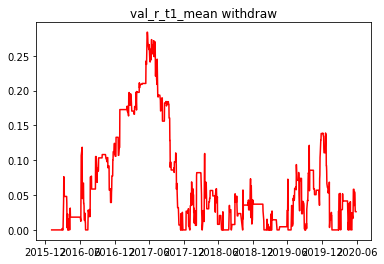

Text(0.5,1,'val_r_t1_median withdraw')

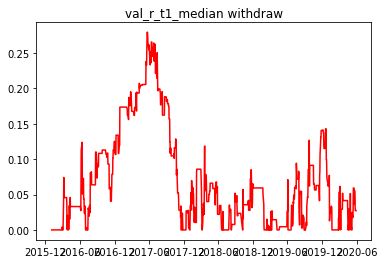

Text(0.5,1,'val_r_t2_mean_0 withdraw')

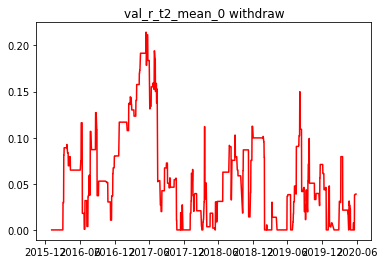

Text(0.5,1,'val_r_t2_median_0 withdraw')

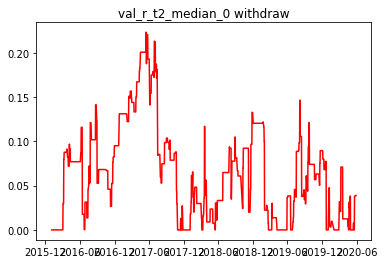

Text(0.5,1,'val_r_t2_mean_1 withdraw')

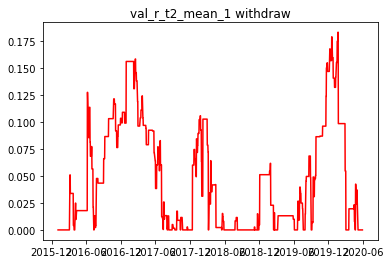

Text(0.5,1,'val_r_t2_median_1 withdraw')

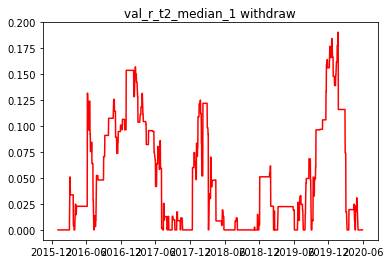

Text(0.5,1,'val_r_t2_mean withdraw')

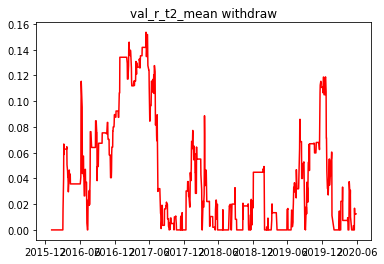

Text(0.5,1,'val_r_t2_median withdraw')

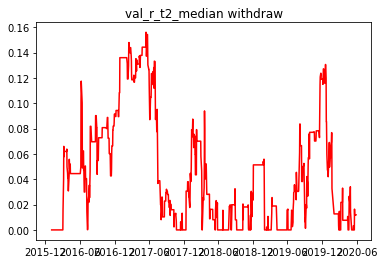

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-29,-0.040462,-0.040462,1.0,-0.013212,-0.013212,1.0,3.308396,2.930731,2.504255,2.211188,...,2.299020,0.038204,3.311457,0.037168,3.051096,0.030938,2.936969,0.030866,2.675058,0.034060
2020-04-30,0.038689,0.038689,1.0,0.048761,0.048761,1.0,3.436395,3.044119,2.626365,2.319007,...,2.319007,0.000000,3.311457,0.037168,3.051096,0.030938,2.936969,0.010077,2.675058,0.013908
2020-05-06,0.023023,0.023023,1.0,0.041515,0.041515,1.0,3.515510,3.114202,2.626365,2.319007,...,2.319007,0.000000,3.320744,0.000000,3.079450,0.000000,2.973555,0.000000,2.699229,0.000000
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,3.515510,3.114202,2.626365,2.319007,...,2.319007,0.000000,3.320744,0.000000,3.079450,0.000000,2.973555,0.000000,2.699229,0.000000
2020-05-08,-0.024800,-0.024800,1.0,0.012000,0.012000,1.0,3.428325,3.036970,2.626365,2.319007,...,2.319007,0.000000,3.360593,0.000000,3.116403,0.000000,2.993479,0.000000,2.717705,0.000000
2020-05-11,0.008448,0.007346,3.0,0.010130,0.012053,3.0,3.457288,3.059281,2.652970,2.346957,...,2.346957,0.000000,3.360593,0.000000,3.116403,0.000000,3.006781,0.000000,2.731680,0.000000
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,3.457288,3.059281,2.652970,2.346957,...,2.346957,0.000000,3.360593,0.000000,3.116403,0.000000,3.006781,0.000000,2.731680,0.000000
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,3.457288,3.059281,2.652970,2.346957,...,2.346957,0.000000,3.360593,0.000000,3.116403,0.000000,3.006781,0.000000,2.731680,0.000000
2020-05-14,-0.019965,-0.019965,1.0,0.024306,0.024306,1.0,3.388262,2.998201,2.652970,2.346957,...,2.346957,0.000000,3.442274,0.000000,3.192149,0.000000,3.047622,0.000000,2.769553,0.000000


In [445]:

day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)

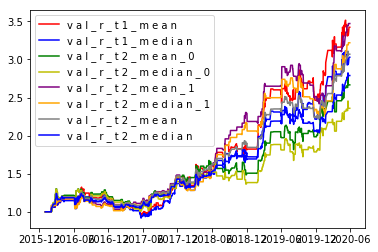

In [446]:
f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
f.savefig('val_curve.png')



--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-29,0.106775,0.104434,0.300980,0.296727,0.083175,0.083175,0.192078,0.189951
2016-03-31,0.001738,0.011904,-0.083595,-0.082165,0.014448,0.014311,-0.036936,-0.036173
2016-04-30,-0.011930,-0.033064,0.005055,-0.005528,-0.017882,-0.022777,-0.006356,-0.014133
2016-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-30,0.006605,0.011832,0.035411,0.049401,-0.060436,-0.063173,-0.011719,-0.006269
2016-07-31,0.010159,-0.016410,-0.077479,-0.092685,0.029635,0.012506,-0.026812,-0.043062
2016-08-31,0.009694,0.009694,0.054699,0.054699,0.004523,0.004523,0.029862,0.029928
2016-09-30,-0.026233,-0.026233,-0.016385,-0.016385,-0.039668,-0.039667,-0.027487,-0.027456


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.018349,0.015935,0.016362,0.014335,0.019294,0.017875,0.017437,0.015807
median,0.003796,0.004043,0.009703,0.009703,0.015035,0.014311,0.009648,0.004576
std,0.057232,0.056695,0.069579,0.068995,0.050280,0.050679,0.047373,0.048179


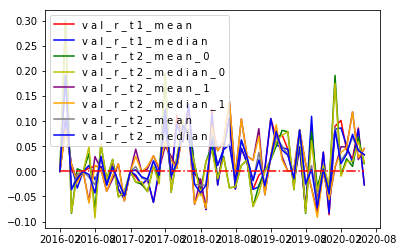


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-03-31,0.173677,0.183081,0.192225,0.190181,0.198410,0.198249,0.195318,0.194215
2016-06-30,-0.005403,-0.021623,0.040645,0.043600,-0.077237,-0.084511,-0.018000,-0.020314
2016-09-30,-0.025180,-0.050819,-0.021832,-0.037955,-0.030285,-0.046417,-0.025831,-0.041947
2016-12-31,-0.072333,-0.068407,-0.067514,-0.067514,-0.059086,-0.051747,-0.063546,-0.060111
2017-03-31,-0.029914,-0.024107,-0.046195,-0.041430,0.070175,0.058284,0.008860,0.005806
2017-06-30,-0.079708,-0.071942,-0.043392,-0.055151,0.040457,0.050349,-0.001312,-0.002566
2017-09-30,0.251810,0.214294,0.170062,0.169627,0.101541,0.103321,0.134431,0.134839
2017-12-31,0.183070,0.197198,0.192961,0.186720,0.094542,0.096328,0.143267,0.140612
2018-03-31,0.031264,0.018847,0.028888,0.009466,0.034329,0.004605,0.031542,0.007061


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.070355,0.062413,0.054536,0.048762,0.074149,0.069837,0.063324,0.058504
median,0.033651,0.030536,0.034201,0.025898,0.078396,0.072451,0.054194,0.052001
std,0.121400,0.113143,0.105829,0.108566,0.105738,0.107218,0.086363,0.089698


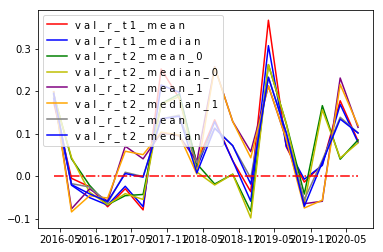


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-12-31,0.094826,0.054372,0.149002,0.126776,0.031684,0.014238,0.090343,0.070507
2017-12-31,0.307021,0.297159,0.288162,0.258230,0.342492,0.344553,0.313865,0.299123
2018-12-31,0.243538,0.208585,0.017993,-0.024109,0.551107,0.484911,0.278032,0.227679
2019-12-31,0.473507,0.418588,0.569307,0.517467,0.157882,0.148977,0.325746,0.297002
2020-12-31,0.274226,0.260807,0.127780,0.123629,0.371703,0.359980,0.253897,0.248898


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.278624,0.247902,0.230449,0.200399,0.290974,0.270532,0.252377,0.228642
median,0.274226,0.260807,0.149002,0.126776,0.342492,0.344553,0.278032,0.248898
std,0.135847,0.132972,0.212407,0.203466,0.201113,0.187017,0.094973,0.093620


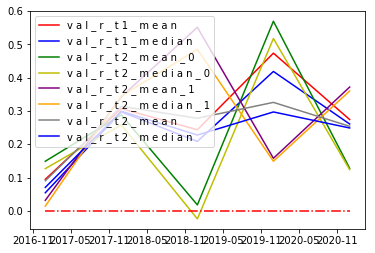

In [447]:
result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()


In [254]:
with pd.ExcelWriter("result.xlsx") as writer:
    for k in sorted(result_dict.keys()):
        result_dict[k].to_excel(writer,sheet_name=k)



In [589]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r','r_t1','r_t2']


mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.15,
]

mask_low_pos = [

    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.1,
    df['close/10ma']<1.1,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic


for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

(199754, 4593560, 0.0435, 0.0435)

(3556357, 4593560, 0.7742, 0.0208)

(4473030, 4593560, 0.9738, 0.0208)

(4301818, 4593560, 0.9365, 0.0203)

(4110067, 4593560, 0.8947, 0.0203)

(1056950, 4593560, 0.2301, 0.0055)

(4348257, 4593560, 0.9466, 0.0049)

(2056374, 4593560, 0.4477, 0.0043)

(1433930, 4593560, 0.3122, 0.0034)

(4580262, 4593560, 0.9971, 0.0034)

(3453794, 4593560, 0.7519, 0.0025)

In [590]:
df_sample = df.loc[mask_final]
features = [col for col in df_sample.columns if col not in ['r_t1','r_t2']+ ['f1_open','f2_close','f2_open','sell_at0','sell_idx','buy_at0']+r_columns 
            and is_numeric_dtype(df_sample.dtypes[col])]
features
mask_y = df_sample[['r_t1','r_t2']].notnull().all(axis=1)
X,Y = df_sample.loc[mask_y,features].fillna(0),df_sample.loc[mask_y,['r_t1','r_t2']]
X.shape,Y.shape
Y.agg(agg_operations)

['open',
 'high',
 'low',
 'close',
 'vol',
 'amt',
 'adj_factor',
 'avg',
 'close0',
 'avg0',
 'pct',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'pb',
 'ps',
 'ps_ttm',
 'total_share',
 'float_share',
 'free_share',
 'total_mv',
 'circ_mv',
 'pb*pe_ttm',
 'pb*pe',
 '5ma',
 '10ma',
 '20ma',
 '40ma',
 '60ma',
 '120ma',
 '250ma',
 'close/5ma',
 'close/10ma',
 'close/20ma',
 'close/40ma',
 'close/60ma',
 'close/120ma',
 'close/250ma',
 '60ma_pct',
 '20ma_pct',
 'p5max_abs_pct',
 'p10max_abs_pct',
 '30ma',
 '30ma_pct',
 'close/30ma',
 'prev_close',
 'day_pct',
 'close0_rank',
 'close0_pct',
 'prev_pct',
 'prev_day_pct',
 '5ma_pct',
 'p5mean_close',
 'p5median_close',
 'p5std_close',
 'p5mean_5ma_pct',
 'p5median_5ma_pct',
 'p5std_5ma_pct',
 'p10mean_close',
 'p10median_close',
 'p10std_close',
 'p10mean_5ma_pct',
 'p10median_5ma_pct',
 'p10std_5ma_pct',
 'p15mean_close',
 'p15median_close',
 'p15std_close',
 'p15mean_5ma_pct',
 'p15median_5ma_pct',
 'p15std_5

((11462, 96), (11462, 2))

,r_t1,r_t2
mean,0.001417,0.003397
median,-0.000499,0.000000
max,0.229508,0.232816
min,-0.191725,-0.189483
std,0.030150,0.038342
size,11462.000000,11462.000000


In [674]:
clf = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50,random_state=0,
                            min_impurity_decrease=3.5e-6,
                           )
# clf = lgbm.LGBMRegressor(max_depth=10,min_child_samples=5,random_state=0,n_estimators=1,learning_rate=1,importance_type ='gain')

clf.fit(X,Y['r_t2'])
importance = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
importance[importance>0]
(importance>0).sum()
# clf.predict(X)



DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=3.5e-06,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

pct                    0.429191
close/5ma              0.207772
close/120ma            0.079053
p15mean-std_5ma_pct    0.077327
volume_ratio           0.073795
p25mean-std_5ma_pct    0.067601
5ma_pct                0.065260
dtype: float64

7

pred  pred_rank  pred_rank_pct
code      date                                          
000001.SZ 2017-09-07  0.008806        1.0       0.205882
          2017-09-08  0.008806        1.0       0.192308
          2017-11-27  0.008806        2.0       0.583333
          2017-11-28  0.008806        1.0       0.375000
          2019-01-24 -0.000083        5.0       0.631579

r_t1                                          r_t2            \
               mean    median       max       min  size      mean    median   
pred                                                                          
-0.004385 -0.006126 -0.005307  0.086370 -0.130778   248 -0.004385 -0.006293   
-0.000083 -0.001069 -0.002477  0.160494 -0.139575  7682 -0.000083 -0.002786   
 0.002526  0.010794  0.008696  0.127209 -0.133858    53  0.002526  0.001649   
 0.003998  0.001288 -0.001038  0.133551 -0.132201   327  0.003998 -0.002695   
 0.008806  0.004391  0.003301  0.175556 -0.191725  2564  0.008806  0.004794   
 0.013974  0.007141  0.004619  0.094779 -0.068572   230  0.013974  0.008098   
 0.035828  0.032610  0.034078  0.229508 -0.088617   297  0.035828  0.034868   
 0.045785  0.039139  0.029542  0.165109 -0.038462    61  0.045785  0.041063   

                                     pred_rank                           \
                max       min  size       mean median    max  min  size   
pred                                                                      
-0.004385  0.098516 -0.130778   248  21.479839   16.0  159.0  1.0   248   
-0.000083  0.195565 -0.166402  7682  10.733403    5.0  141.0  1.0  7682   
 0.002526  0.151590 -0.111958    53  17.490566    8.0  140.0  1.0    53   
 0.003998  0.168476 -0.131595   327  10.605505    5.0   53.0  1.0   327   
 0.008806  0.194301 -0.189483  2564   4.001170    1.0   88.0  1.0  2564   
 0.013974  0.144592 -0.080645   230   4.086957    1.0   36.0  1.0   230   
 0.035828  0.232816 -0.088617   297   1.124579    1.0    2.0  1.0   297   
 0.045785  0.205608 -0.066434    61   1.000000    1.0    1.0  1.0    61   

          pred_rank_pct                                 
                   mean    median  max       min  size  
pred                                                    
-0.004385      0.974958  1.000000  1.0  0.750000   248  
-0.000083      0.645556  0.628931  1.0  0.375000  7682  
 0.002526      0.565972  0.586957  1.0  0.230769    53  
 0.003998      0.331394  0.307692  1.0  0.030303   327  
 0.008806      0.292441  0.250000  1.0  0.020408  2564  
 0.013974      0.123717  0.098387  1.0  0.006098   230  
 0.035828      0.218273  0.268116  1.0  0.012579   297  
 0.045785      0.058747  0.071090  0.5  0.006803    61

<BarContainer object of 8 artists>

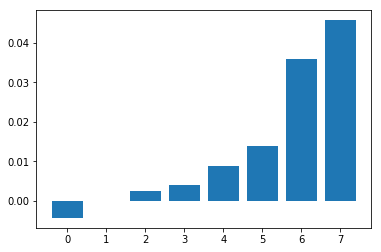

<BarContainer object of 8 artists>

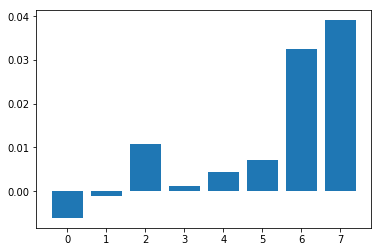

In [675]:
y_pred = pd.DataFrame(clf.predict(X),index=Y.index,columns=['pred'])
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.head()
Y2 = Y.join(y_pred,how='left')
res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
res
plt.bar(np.arange(len(res)),res[('r_t2','mean')])
plt.show()
plt.bar(np.arange(len(res)),res[('r_t1','mean')])

# clf.predict(X)

In [676]:
tmp_day = Y2[(Y2['pred']>0.01) & (Y2['pred_rank']<=1)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()

(235, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-01-04  0.086088  0.086088    2  0.093477  0.093477    2
2016-02-05  0.074830  0.074830    1  0.095238  0.095238    1
2016-02-16  0.155877  0.155877    1  0.200503  0.200503    1
2016-02-25  0.052837  0.052837    2  0.088135  0.088135    2
2016-02-29  0.021153  0.006272    4  0.089219  0.068031    4

In [677]:
day_r = tmp_day.reindex(date).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
# day_r.tail(30)

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-04-15,0.007218,0.007218,1.0,-0.009144,-0.009144,1.0,1042,0.000000,0.000000,-0.009144,-0.009144
2020-04-16,0.029542,0.029542,1.0,0.025849,0.025849,1.0,1043,0.025849,0.025849,0.000000,0.000000
2020-04-17,-0.002249,-0.002249,1.0,0.008355,0.008355,1.0,1044,0.000000,0.000000,0.008355,0.008355
2020-04-20,0.010216,0.010216,1.0,0.026447,0.026447,1.0,1045,0.026447,0.026447,0.000000,0.000000
2020-04-21,0.040232,0.040232,2.0,0.035112,0.035112,2.0,1046,0.000000,0.000000,0.035112,0.035112
2020-04-22,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1047,0.000000,0.000000,0.000000,0.000000
2020-04-23,-0.004503,-0.004503,2.0,0.015443,0.015443,2.0,1048,0.000000,0.000000,0.015443,0.015443
2020-04-24,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1049,0.000000,0.000000,0.000000,0.000000
2020-04-27,-0.084571,-0.084571,1.0,-0.065143,-0.065143,1.0,1050,0.000000,0.000000,-0.065143,-0.065143


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-05,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-06,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-07,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-08,1.086088,1.086088,1.0,1.0,1.093477,1.093477


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2016-01-04,0.086088,0.086088,2.0,0.093477,0.093477,2.0,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738


Text(0.5,1,'val_r_t1_mean withdraw')

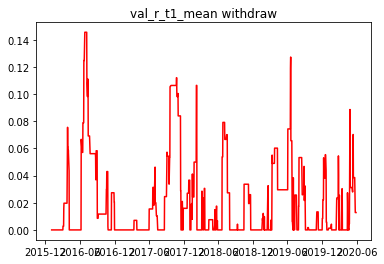

Text(0.5,1,'val_r_t1_median withdraw')

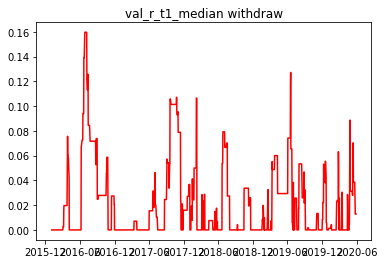

Text(0.5,1,'val_r_t2_mean_0 withdraw')

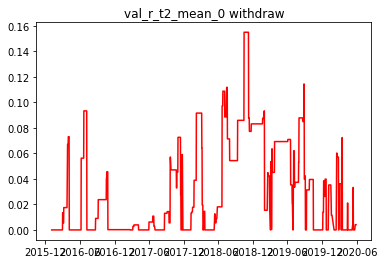

Text(0.5,1,'val_r_t2_median_0 withdraw')

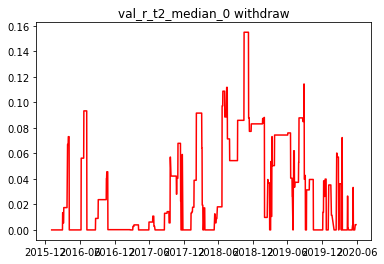

Text(0.5,1,'val_r_t2_mean_1 withdraw')

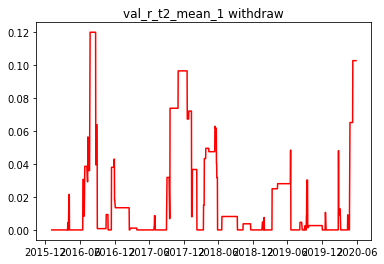

Text(0.5,1,'val_r_t2_median_1 withdraw')

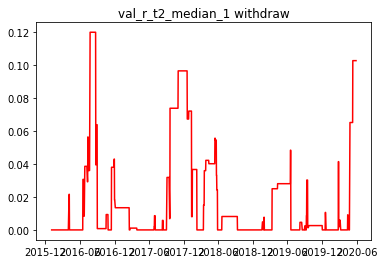

Text(0.5,1,'val_r_t2_mean withdraw')

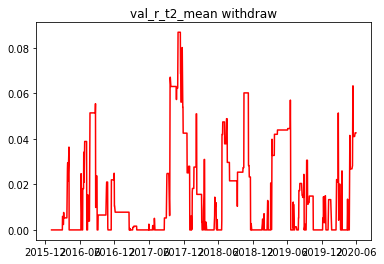

Text(0.5,1,'val_r_t2_median withdraw')

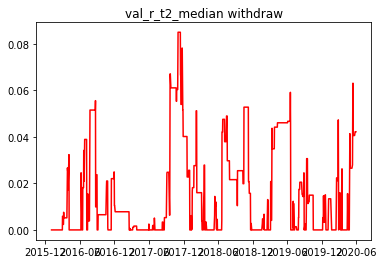

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-29,NaN,NaN,NaN,NaN,NaN,NaN,14.104938,13.927628,4.038960,4.082968,...,4.082968,0.000000,6.829727,0.065143,6.817345,0.065143,5.355555,0.026826,5.370509,0.026516
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,14.104938,13.927628,4.038960,4.082968,...,4.082968,0.000000,6.829727,0.065143,6.817345,0.065143,5.355555,0.026826,5.370509,0.026516
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,14.104938,13.927628,4.038960,4.082968,...,4.082968,0.000000,6.829727,0.065143,6.817345,0.065143,5.355555,0.026826,5.370509,0.026516
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,14.104938,13.927628,4.038960,4.082968,...,4.082968,0.000000,6.829727,0.065143,6.817345,0.065143,5.355555,0.026826,5.370509,0.026516
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,14.104938,13.927628,4.038960,4.082968,...,4.082968,0.000000,6.829727,0.065143,6.817345,0.065143,5.355555,0.026826,5.370509,0.026516
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,14.153227,13.975309,4.023875,4.067719,...,4.082968,0.003735,6.829727,0.065143,6.817345,0.065143,5.355555,0.028234,5.370509,0.027936
2020-05-12,-0.013605,-0.013605,1.0,-0.040136,-0.040136,1.0,13.960667,13.785170,4.023875,4.067719,...,4.082968,0.003735,6.829727,0.102664,6.817345,0.102664,5.355555,0.052159,5.370509,0.051750
2020-05-13,-0.030345,-0.030345,1.0,-0.029655,-0.029655,1.0,13.537033,13.366861,3.904546,3.947089,...,4.082968,0.033279,6.829727,0.102664,6.817345,0.102664,5.355555,0.063299,5.370509,0.062981
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,13.537033,13.366861,3.904546,3.947089,...,4.082968,0.033279,6.829727,0.102664,6.817345,0.102664,5.355555,0.063299,5.370509,0.062981


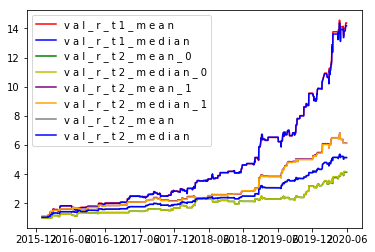


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-29,0.335683,0.316218,0.185217,0.162162,0.314837,0.314837,0.252921,0.241908
2016-03-31,-0.027003,-0.026677,-0.067071,-0.067071,0.014096,0.020858,-0.021429,-0.017202
2016-04-30,0.203369,0.222908,0.140102,0.156294,0.037358,0.037358,0.080066,0.086039
2016-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-30,-0.145602,-0.159594,-0.093388,-0.093388,0.034487,0.024631,-0.021622,-0.026799
2016-07-31,0.104683,0.104683,0.203902,0.203902,-0.084579,-0.084579,0.032716,0.032534
2016-08-31,-0.002277,-0.002277,-0.009027,-0.009027,0.063739,0.063739,0.029248,0.029296
2016-09-30,-0.003127,-0.003127,-0.014855,-0.014855,0.000000,0.000000,-0.006540,-0.006531


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.046356,0.046153,0.025586,0.025588,0.031589,0.031513,0.027920,0.027878
median,0.024465,0.023735,0.000000,0.000000,0.004704,0.009009,0.015198,0.015109
std,0.080880,0.080712,0.073748,0.073224,0.066898,0.066262,0.049778,0.048992


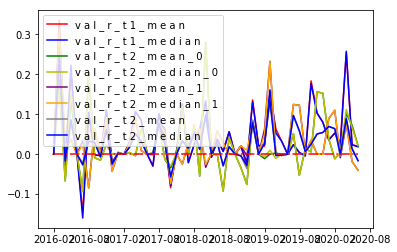


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-03-31,0.403727,0.383735,0.105723,0.084214,0.412194,0.421611,0.265801,0.260445
2016-06-30,0.028156,0.027739,0.033630,0.048310,0.073134,0.062910,0.056713,0.056934
2016-09-30,0.156766,0.156766,0.175312,0.175312,0.039299,0.039299,0.094601,0.094515
2016-12-31,0.125254,0.125254,0.024125,0.024125,0.076454,0.076454,0.053609,0.053642
2017-03-31,0.141228,0.141228,0.000276,0.000276,0.120328,0.120328,0.069383,0.069460
2017-06-30,0.053780,0.053780,0.065030,0.065030,0.007722,0.007722,0.030469,0.030433
2017-09-30,0.043670,0.054860,0.024347,0.029546,0.063097,0.051521,0.046860,0.042327
2017-12-31,0.110088,0.110088,0.088592,0.088592,0.001851,0.001851,0.037416,0.037697
2018-03-31,0.232206,0.234609,0.298311,0.294764,0.069114,0.077319,0.167722,0.171586


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.157005,0.155820,0.080876,0.081493,0.105790,0.105729,0.092114,0.092303
median,0.129888,0.132819,0.058329,0.058329,0.077279,0.081382,0.063048,0.063197
std,0.119519,0.115029,0.113956,0.113602,0.116031,0.116608,0.079016,0.078846


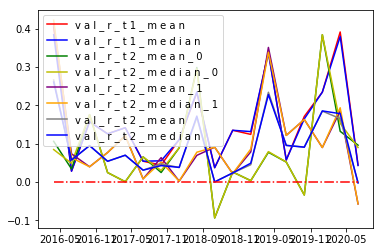


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-12-31,0.871252,0.843852,0.366696,0.359143,0.695448,0.690493,0.538411,0.532215
2017-12-31,0.369515,0.384199,0.231663,0.237913,0.202436,0.189342,0.214838,0.209922
2018-12-31,0.694244,0.708601,0.270440,0.266969,0.283472,0.302129,0.277865,0.286886
2019-12-31,1.098962,1.083871,0.555715,0.557633,0.918101,0.900375,0.763097,0.754089
2020-12-31,0.452179,0.438036,0.240076,0.256076,0.116721,0.124469,0.163278,0.174349


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.697230,0.691712,0.332918,0.335547,0.443235,0.441362,0.391498,0.391492
median,0.694244,0.708601,0.270440,0.266969,0.283472,0.302129,0.277865,0.286886
std,0.299637,0.289886,0.135605,0.132693,0.346132,0.337669,0.252920,0.246140


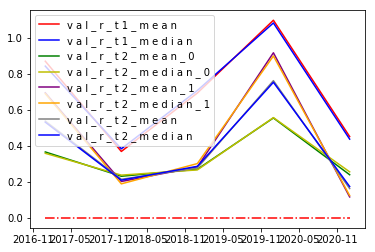

In [678]:

day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()


DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=4e-06,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

pct            0.599415
close/5ma      0.290177
close/120ma    0.110407
dtype: float64

3

pred  pred_rank  pred_rank_pct
code      date                                          
000001.SZ 2017-09-07  0.008806        1.0       0.205882
          2017-09-08  0.008806        1.0       0.192308
          2017-11-27  0.008806        2.0       0.583333
          2017-11-28  0.008806        1.0       0.375000
          2019-01-24  0.000654        5.0       0.631579

r_t1                                          r_t2            \
              mean    median       max       min  size      mean    median   
pred                                                                         
0.000654 -0.000618 -0.002328  0.165109 -0.139575  8548  0.000654 -0.002470   
0.002526  0.010794  0.008696  0.127209 -0.133858    53  0.002526  0.001649   
0.008806  0.004391  0.003301  0.175556 -0.191725  2564  0.008806  0.004794   
0.035828  0.032610  0.034078  0.229508 -0.088617   297  0.035828  0.034868   

                                    pred_rank                           \
               max       min  size       mean median    max  min  size   
pred                                                                     
0.000654  0.205608 -0.166402  8548   7.748362    4.0  141.0  1.0  8548   
0.002526  0.151590 -0.111958    53  17.000000    8.0  140.0  1.0    53   
0.008806  0.194301 -0.189483  2564   3.420827    1.0   88.0  1.0  2564   
0.035828  0.232816 -0.088617   297   1.000000    1.0    1.0  1.0   297   

         pred_rank_pct                                 
                  mean    median  max       min  size  
pred                                                   
0.000654      0.630210  0.611111  1.0  0.503448  8548  
0.002526      0.548699  0.562500  1.0  0.153846    53  
0.008806      0.275235  0.238095  1.0  0.011848  2564  
0.035828      0.216097  0.253623  1.0  0.010870   297

<BarContainer object of 4 artists>

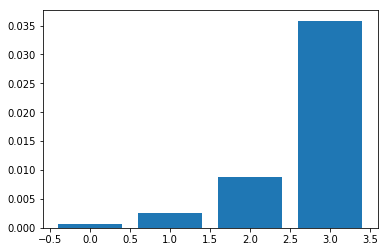

<BarContainer object of 4 artists>

(113, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-01-04  0.086088  0.086088    2  0.093477  0.093477    2
2016-02-05  0.074830  0.074830    1  0.095238  0.095238    1
2016-02-25  0.052837  0.052837    2  0.088135  0.088135    2
2016-02-29  0.021153  0.006272    4  0.089219  0.068031    4
2016-03-04 -0.002739 -0.002739    2  0.008147  0.008147    2

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.0,0.0
2020-05-26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1068,0.000000,0.000000,0.0,0.0
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.000000,0.000000,0.0,0.0
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.0,0.0
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.0,0.0


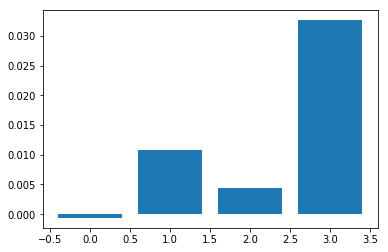

In [680]:
clf = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50,random_state=0,
                            min_impurity_decrease=4e-6,
                           )
# clf = lgbm.LGBMRegressor(max_depth=10,min_child_samples=5,random_state=0,n_estimators=1,learning_rate=1,importance_type ='gain')

clf.fit(X,Y['r_t2'])
importance = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
importance[importance>0]
(importance>0).sum()
# clf.predict(X)



y_pred = pd.DataFrame(clf.predict(X),index=Y.index,columns=['pred'])
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.head()
Y2 = Y.join(y_pred,how='left')
res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
res
plt.bar(np.arange(len(res)),res[('r_t2','mean')])
plt.show()
plt.bar(np.arange(len(res)),res[('r_t1','mean')])

# clf.predict(X)



tmp_day = Y2[(Y2['pred']>0.01)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)

,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-05,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-06,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-07,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-08,1.086088,1.086088,1.0,1.0,1.093477,1.093477


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2016-01-04,0.086088,0.086088,2.0,0.093477,0.093477,2.0,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.086088,1.086088,1.0,1.0,1.093477,1.093477,1.046738,1.046738


Text(0.5,1,'val_r_t1_mean withdraw')

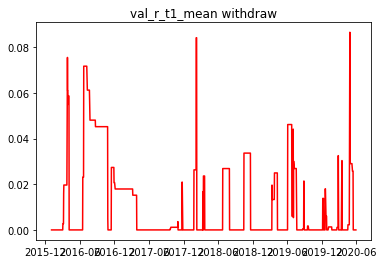

Text(0.5,1,'val_r_t1_median withdraw')

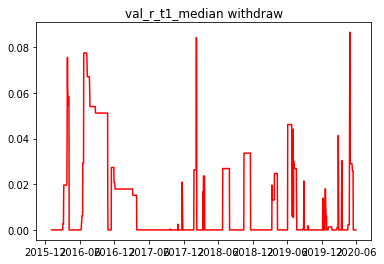

Text(0.5,1,'val_r_t2_mean_0 withdraw')

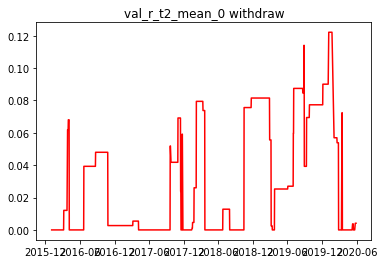

Text(0.5,1,'val_r_t2_median_0 withdraw')

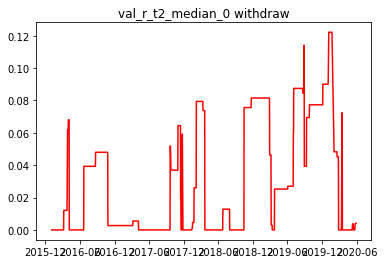

Text(0.5,1,'val_r_t2_mean_1 withdraw')

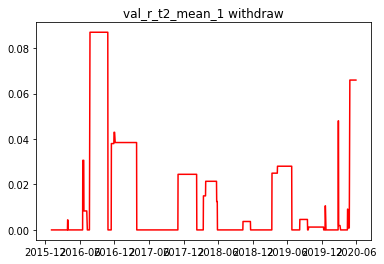

Text(0.5,1,'val_r_t2_median_1 withdraw')

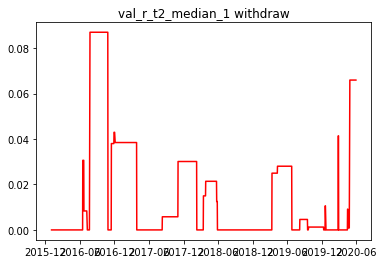

Text(0.5,1,'val_r_t2_mean withdraw')

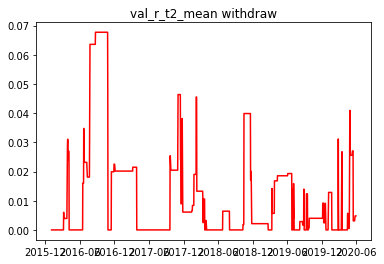

Text(0.5,1,'val_r_t2_median withdraw')

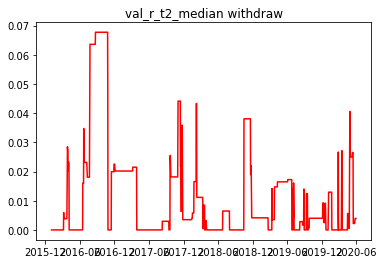

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-29,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500


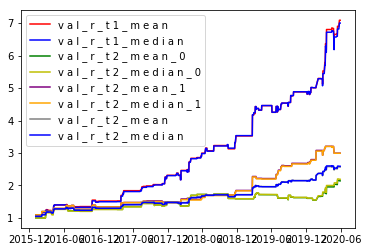


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-29,0.155558,0.138718,0.185217,0.162162,0.095238,0.095238,0.138219,0.127206
2016-03-31,-0.054986,-0.054669,-0.054269,-0.054269,0.014096,0.020858,-0.019909,-0.016141
2016-04-30,0.184085,0.203310,0.140102,0.156294,0.060238,0.060238,0.098439,0.105554
2016-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-30,-0.062195,-0.077553,-0.039301,-0.039301,0.067005,0.056840,0.014228,0.009402
2016-07-31,0.025471,0.025471,0.000000,0.000000,-0.078091,-0.078091,-0.041368,-0.041418
2016-08-31,0.003009,0.003009,-0.009027,-0.009027,0.000000,0.000000,-0.004428,-0.004422
2016-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.035287,0.035135,0.013797,0.014035,0.020329,0.020295,0.016915,0.017008
median,0.003009,0.003009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.063714,0.064633,0.052928,0.052647,0.049906,0.049509,0.037026,0.036822


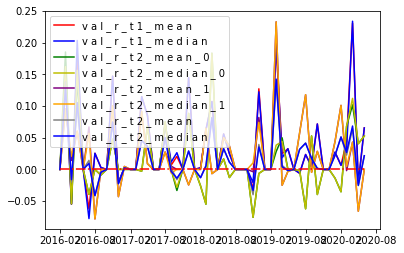


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-03-31,0.092018,0.076465,0.120896,0.099092,0.110677,0.118083,0.115558,0.109011
2016-06-30,0.110441,0.109990,0.095295,0.110850,0.131280,0.120502,0.114067,0.115948
2016-09-30,0.028557,0.028557,-0.009027,-0.009027,-0.078091,-0.078091,-0.045613,-0.045658
2016-12-31,0.126523,0.126523,0.047573,0.047573,0.058218,0.058218,0.053020,0.053027
2017-03-31,0.114853,0.114853,-0.002773,-0.002773,0.091313,0.091313,0.045610,0.045671
2017-06-30,0.085155,0.085155,0.068135,0.068135,0.009009,0.009009,0.036401,0.036363
2017-09-30,0.101137,0.112944,0.039261,0.044535,0.032785,0.021539,0.035877,0.032504
2017-12-31,0.141909,0.141909,0.057211,0.057211,-0.024472,-0.024472,0.014657,0.014930
2018-03-31,0.179257,0.179257,0.089285,0.089285,0.057642,0.057642,0.073436,0.073542


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.110252,0.109324,0.042966,0.044426,0.060041,0.060036,0.051209,0.051777
median,0.096578,0.100331,0.043417,0.046054,0.057930,0.057930,0.040529,0.040367
std,0.080712,0.077636,0.070185,0.073367,0.074283,0.074965,0.055641,0.057122


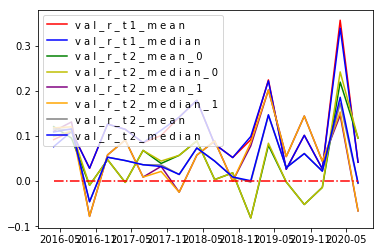


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2016-12-31,0.399550,0.379057,0.266182,0.259185,0.225804,0.222221,0.245092,0.239878
2017-12-31,0.521185,0.537497,0.170325,0.176264,0.109416,0.097335,0.139003,0.135624
2018-12-31,0.524875,0.534804,0.073566,0.073566,0.241752,0.250207,0.157806,0.161450
2019-12-31,0.422178,0.419673,0.007710,0.012014,0.514661,0.514661,0.280040,0.281206
2020-12-31,0.413635,0.395449,0.335960,0.360763,0.070514,0.077219,0.167228,0.181242


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.456284,0.453296,0.170749,0.176358,0.232429,0.232329,0.197834,0.199880
median,0.422178,0.419673,0.170325,0.176264,0.225804,0.222221,0.167228,0.181242
std,0.061477,0.077009,0.134563,0.140036,0.174022,0.174940,0.061219,0.059512


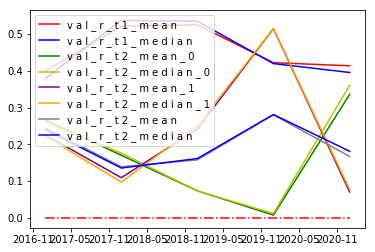

In [681]:
day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [682]:
clf.tree_

In [708]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=features,  
#                    filled=True)
import graphviz

graph = tree.export_graphviz(clf, out_file=None, feature_names=features)
print(graph)
# graph
graphviz.Source(graph,format='png')

digraph Tree {
node [shape=box] ;
0 [label="pct <= -5.436\nmse = 0.001\nsamples = 11462\nvalue = 0.003"] ;
1 [label="close/120ma <= 1.244\nmse = 0.003\nsamples = 350\nvalue = 0.031"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="mse = 0.002\nsamples = 297\nvalue = 0.036"] ;
1 -> 2 ;
3 [label="mse = 0.003\nsamples = 53\nvalue = 0.003"] ;
1 -> 3 ;
4 [label="close/5ma <= 0.993\nmse = 0.001\nsamples = 11112\nvalue = 0.003"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="mse = 0.001\nsamples = 2564\nvalue = 0.009"] ;
4 -> 5 ;
6 [label="mse = 0.001\nsamples = 8548\nvalue = 0.001"] ;
4 -> 6 ;
}


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [703]:
import importlib
importlib.reload(graphviz)
# importlib.reload(sklearn)

<module 'graphviz' from 'C:\\Users\\dell-pc\\Anaconda3.6\\lib\\site-packages\\graphviz\\__init__.py'>

In [706]:
import Image

ImportError: No module named 'Image'